<a href="https://colab.research.google.com/github/AQUANGEL/E2E_CRNN_for_OCR_text_sequences/blob/master/Copy_of_OCR_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning OCR Project By Tomer Twena, I.D. 313583551

Importing all the relevant libraries (and maybe some redundant too)

In [1]:
import tensorflow as tf
import collections
import glob
import os

# Importing drive method from colab for accessing google drive
from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from pathlib import Path
from collections import Counter

from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array
from keras import layers
from keras.models import Model
from keras.optimizers import Adadelta
from keras.models import Sequential
from keras.layers import Lambda, MaxPooling2D, Input
from keras.layers import Dense, Reshape, Flatten, Dropout, LSTM
from keras.layers import Conv2D, BatchNormalization, Bidirectional
from keras import backend
import re

print(tf.__version__)
# drive.mount('/content/drive')
# res = !ls "/content/drive/My Drive/1"

2.3.0


download the mysynth dataset and extract it:

In [2]:
!curl -LO https://github.com/AQUANGEL/E2E_CRNN_for_OCR_text_sequences/raw/master/1.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   153  100   153    0     0    204      0 --:--:-- --:--:-- --:--:--   204
100 20.0M  100 20.0M    0     0  6713k      0  0:00:03  0:00:03 --:--:-- 18.1M


In [3]:
!unzip -qq 1.zip

In [4]:


# Path to the data directory
data_dir = Path("/content/1/")

print(list(data_dir.glob("*")))

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [re.search(r"_(\w+)_", img).group(1) for img in images]

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 128
img_height = 32

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
# downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

labels = [('-' * (max_length - len(x))) + x for x in labels]

characters = set(char for label in labels for char in label)
print("Characters present: ", characters)
print("Number of unique characters: ", len(characters))

[PosixPath('/content/1/75_overtaxing_54755.jpg'), PosixPath('/content/1/271_gentility_32157.jpg'), PosixPath('/content/1/377_enlargements_25855.jpg'), PosixPath('/content/1/404_apollinaire_3405.jpg'), PosixPath('/content/1/258_watt_85689.jpg'), PosixPath('/content/1/456_rearms_62877.jpg'), PosixPath('/content/1/217_HOD_36400.jpg'), PosixPath('/content/1/307_Digger_21608.jpg'), PosixPath('/content/1/258_banqueters_5823.jpg'), PosixPath('/content/1/164_rationals_62571.jpg'), PosixPath('/content/1/168_recto_63423.jpg'), PosixPath('/content/1/487_Quietest_61876.jpg'), PosixPath('/content/1/326_DISESTEEM_22259.jpg'), PosixPath('/content/1/233_Uncombed_81928.jpg'), PosixPath('/content/1/8_COGITATIVE_14733.jpg'), PosixPath('/content/1/288_ADIDAS_1026.jpg'), PosixPath('/content/1/349_Gracchus_33294.jpg'), PosixPath('/content/1/94_Laggard_43123.jpg'), PosixPath('/content/1/494_WHITISH_86382.jpg'), PosixPath('/content/1/466_Catechisms_12006.jpg'), PosixPath('/content/1/192_kigali_42459.jpg'), Po

In [5]:
# print(labels)
max_length2 = max([len(label) for label in labels])
print(max_length)
print(max_length2)

19
19


In [6]:
for img_path in images:
  image = cv.imread(img_path)
  image = cv.resize(image, (img_width, img_height))
  cv.imwrite(img_path, image)

In [7]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_jpeg(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

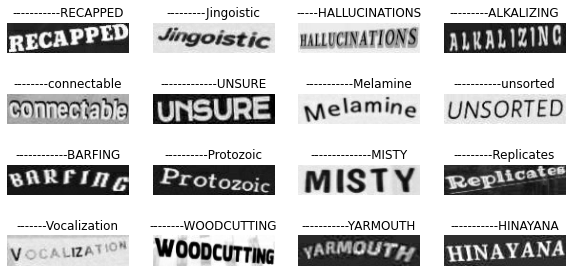

In [9]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [10]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [11]:


# model = Sequential()
# model.add(Input(shape=(128, 32, 1)))
input_img = Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
labels = layers.Input(name="label", shape=(None,), dtype="float32")

# model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
conv1 = Conv2D(64, (3, 3), activation="relu", padding="same",
               kernel_initializer="he_normal", name="Conv1")(input_img)

# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
max_pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2), name="max_pool1")(conv1)

# model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
conv2 = Conv2D(64, (3, 3), activation="relu", padding="same",
               kernel_initializer="he_normal", name="Conv2")(max_pool1)

# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
max_pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2,2), name="max_pool2")(conv2)

# model.add(Conv2D(256, (3, 3), activation="relu", padding="same"))
conv3 = Conv2D(256, (3, 3), activation="relu", padding="same",
               kernel_initializer="he_normal", name="Conv3")(max_pool2)

# model.add(Conv2D(256, (3, 3), activation="relu", padding="same"))
conv4 = Conv2D(256, (3, 3), activation="relu", padding="same",
               kernel_initializer="he_normal", name="Conv4")(conv3)

# model.add(MaxPooling2D(pool_size=(1, 2), strides=(2,2)))
max_pool3 = MaxPooling2D(pool_size=(1, 2), strides=(2,2), name="max_pool3")(conv4)

# model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
conv5 = Conv2D(512, (3, 3), activation="relu", padding="same",
               kernel_initializer="he_normal", name="Conv5")(max_pool3)

# model.add(BatchNormalization())
batch_normalization1 = BatchNormalization(name="BatchNormalization1")(conv5)

# model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
conv6 = Conv2D(512, (3, 3), activation="relu", padding="same",
               kernel_initializer="he_normal", name="Conv6")(batch_normalization1)

# model.add(BatchNormalization())
batch_normalization2 = BatchNormalization(name="BatchNormalization2")(conv6)

# model.add(MaxPooling2D(pool_size=(1, 2), strides=(2,2)))
max_pool4 = MaxPooling2D(pool_size=(1, 2), strides=(2,2), name="max_pool4")(batch_normalization2)

# model.add(Conv2D(512, (2, 2), padding="same", activation="relu"))
conv7 = Conv2D(512, (2, 2), activation="relu", padding="same",
               kernel_initializer="he_normal", name="Conv7")(max_pool4)

# model.add(Reshape((8, 1024)))
# this could've been better if i would've used the max length to calculate the desired shape
reshape = Reshape((64, 128), name="Reshape")(conv7)

# model.add(Dense(64, activation='relu'))
dense1 = Dense(64, activation='relu', name="Dense1")(reshape)

# model.add(Bidirectional(LSTM(256, input_shape=(8, 1024), return_sequences=True)))
bi_lstm1 = Bidirectional(LSTM(256, input_shape=(64, 128), return_sequences=True), name="BiLSTM1")(dense1)

# model.add(Bidirectional(LSTM(256, input_shape=(8, 1024), return_sequences=True, go_backwards=True)))
bi_lstm2 = Bidirectional(LSTM(256, input_shape=(64, 128), return_sequences=True), name="BiLSTM2")(bi_lstm1)

# model.add(Dense(num_of_character, activation='softmax'))
dense2 = Dense(len(characters) + 1, activation='softmax', name="Dense2")(bi_lstm2)

# Optimizer
opt = Adadelta()

# Add CTC layer for calculating CTC loss at each step
output = CTCLayer(name="ctc_loss")(labels, dense2)

# Define the model
model = Model(inputs=[input_img, labels], outputs=output, name="ocr_model_v1")

# Compile the model and return
model.compile(optimizer=opt)

model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 32, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 32, 64)  640         image[0][0]                      
__________________________________________________________________________________________________
max_pool1 (MaxPooling2D)        (None, 64, 16, 64)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 64, 16, 64)   36928       max_pool1[0][0]                  
_______________________________________________________________________________________

In [12]:
epochs = 20
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(train_dataset,validation_data=validation_dataset,
    epochs=epochs ,callbacks=[early_stopping],
)

Epoch 1/20
585/585 [==============================] - 1318s 2s/step - loss: 80.2192 - val_loss: 38.5385
Epoch 2/20
585/585 [==============================] - 1315s 2s/step - loss: 36.7193 - val_loss: 35.7045
Epoch 3/20
585/585 [==============================] - 1314s 2s/step - loss: 35.0816 - val_loss: 34.6701
Epoch 4/20
585/585 [==============================] - 1304s 2s/step - loss: 34.3179 - val_loss: 34.0674
Epoch 5/20
585/585 [==============================] - 1295s 2s/step - loss: 33.8726 - val_loss: 33.6914
Epoch 6/20
585/585 [==============================] - 1293s 2s/step - loss: 33.5752 - val_loss: 33.4291
Epoch 7/20
585/585 [==============================] - 1290s 2s/step - loss: 33.3548 - val_loss: 33.2395
Epoch 8/20
585/585 [==============================] - 1283s 2s/step - loss: 33.1841 - val_loss: 33.0933
Epoch 9/20
585/585 [==============================] - 1289s 2s/step - loss: 33.0476 - val_loss: 32.9811
Epoch 10/20
585/585 [==============================] - 1293s 2s/

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 128, 32, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 128, 32, 64)       640       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 64, 16, 64)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 64, 16, 64)        36928     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 32, 8, 64)         0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 32, 8, 256)        147712    
_________________________________________________________________
Conv4 (Conv2D)               (None, 32, 8, 256)       

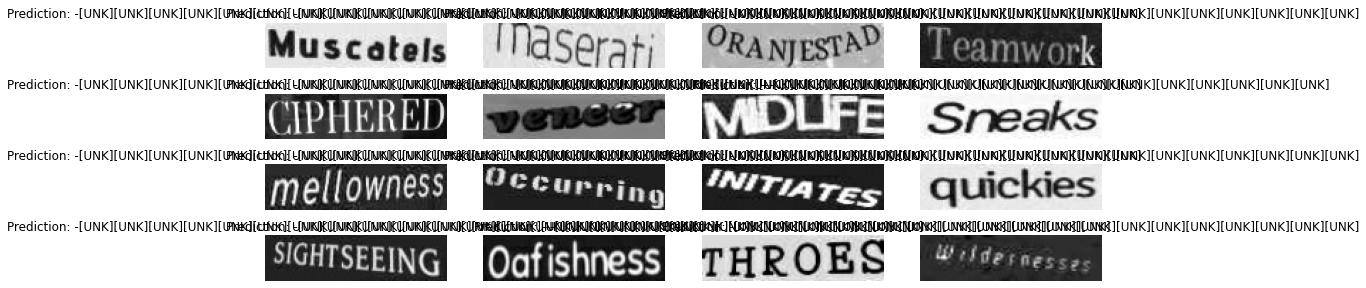

In [13]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="Dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [14]:
pred_texts

['-[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]',
 '-[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]',
 '-[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]',
 '-[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]',
 '-[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]',
 '-[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]',
 '-[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]',
 '---[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]',
 '-[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]',
 '-[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]',
 '-[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]


```
@InProceedings{Jaderberg14c,
  author       = "Max Jaderberg and Karen Simonyan and Andrea Vedaldi and Andrew Zisserman",
  title        = "Synthetic Data and Artificial Neural Networks for Natural Scene Text Recognition",
  booktitle    = "Workshop on Deep Learning, NIPS",
  year         = "2014",
}
                
@Article{Jaderberg16,
  author       = "Max Jaderberg and Karen Simonyan and Andrea Vedaldi and Andrew Zisserman",
  title        = "Reading Text in the Wild with Convolutional Neural Networks",
  journal      = "International Journal of Computer Vision",
  number       = "1",
  volume       = "116",
  pages        = "1--20",
  month        = "jan",
  year         = "2016",
}
```



